<a href="https://colab.research.google.com/github/mritogether/ESMRMB2024_Hardware_to_Map/blob/main/02_sequence_design_for_mapping/notebooks/s01_from_1d_fid_to_1d_se_sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# s01_from_1d_fid_to_1d_se (solution)
Macroscopic field inhomogeneity can accelerate the decay of NMR signals. We can use a refocusing RF pulse to reduce its effect and produce an echo, a.k.a. *spin echo (SE)* or Hahn echo. In this exercise, we will also introduce *gradients* for 1D spatial encoding.      
    
**Exercise**           
If you have no clue, search "hint" for hints.
1. This exercise starts from 1D FID. Please add another RF event between the excitation pulse and the ADC to create an echo in the middle of the ADC. Which flip angle generates the strongest echo? What is the shape of the reconstructed spectrum?      
**Answer:** The refocusing pulse rf_ref is implemented with the timings t_sp and t_spex. The flip angle of the 180 deg generates the strongest echo. The reconstructed spectrum is a peak.
2. Add gradients (prephaser, spoilers, readout) to achieve 1D spatial encoding in the readout direction. What is the shape of the reconstructed spectrum? Why it is different from the one in Question 1?      
**Answer** The reconstructed spectrum is a plateau due to the 1D spatial encoding.
3. Add more refocusing RF pulses and ADCs to retrieve the spin echo in every ADC. What is the numerical value of the decay rate of the echo peak? Is this T1, T2, or T2*?      
**Answer** Setting the n_echo from 1 to e.g. 10 can achieve multi spin echoes. 1/T2star = 1/T2 * 1/T2dash. T2dash represents macroscopic field inhomogeneity. T2 represents microscopic inhomogeneity. At the echo peak, the macroscopic inhomogeneity effect is eliminated by the refocusing pulse. Therefore, T2 is the numerical value of the decay rate of the echo peak.

In [1]:
#@title 1D SE - environment setup (just need to run it once)
!pip show pypulseq || pip install pypulseq &> /dev/null
import math
import warnings
import numpy as np
from matplotlib import pyplot as plt
import pypulseq as pp
# for simulation
!pip show MRzeroCore || pip install MRzeroCore
import MRzeroCore as mr0
import torch

/usr/local/lib/python3.10/dist-packages/sigpy/config.py:15: UserWarning: Importing cupy failed. For more details, see the error stack below:

Failed to import CuPy.

If you installed CuPy via wheels (cupy-cudaXXX or cupy-rocm-X-X), make sure that the package matches with the version of CUDA or ROCm installed.

On Linux, you may need to set LD_LIBRARY_PATH environment variable depending on how you installed CUDA/ROCm.
On Windows, try setting CUDA_PATH environment variable.

Check the Installation Guide for details:
  https://docs.cupy.dev/en/latest/install.html

Original error:
  ImportError: libcuda.so.1: cannot open shared object file: No such file or directory

  warnings.warn(


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.3/399.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.5/454.5 kB 17.6 MB/s eta 0:00:00


TR fill: 65.2 ms
Timing check passed successfully


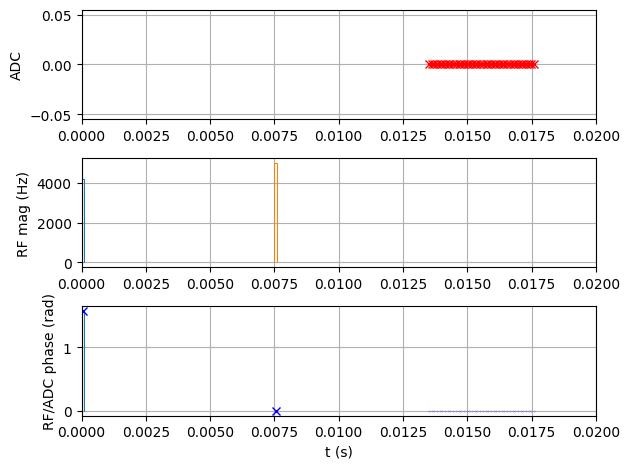

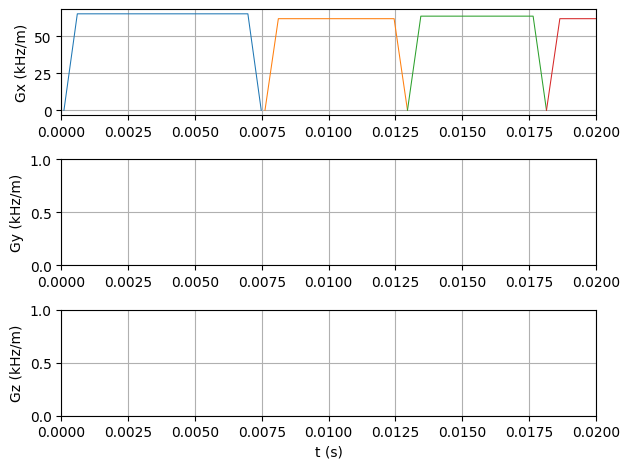

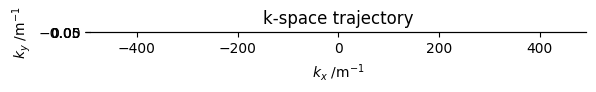

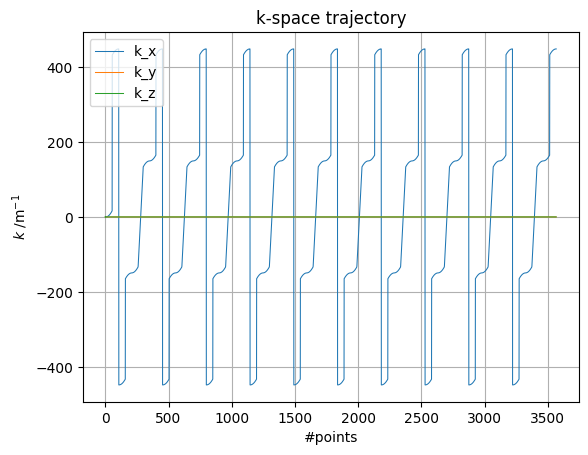

'16355cce53e30b55a8ee7681d00715d0'

In [2]:
#@title 1D SE - sequence
experiment_id = 's01_1d_se'
# %% SETUP system
# choose the scanner limits
system = pp.Opts(
        max_grad=25,       # the portable scanner's limits are 25, 40 and 35 mT/m for X, Y and Z axes
        grad_unit="mT/m",
        max_slew=50,       # the portable scanner's limits are 50, 80 and 70 mT/m/ms for X, Y and Z, respectively
        slew_unit="T/m/s",
        rf_ringdown_time=15e-6,
        rf_dead_time=15e-6,
        adc_dead_time=0e-6 )
# Create a new sequence object
seq = pp.Sequence(system)

# %% DEFINE the sequence, FOV, resolution, and other parameters
fov_mm = 150 # Define FOV in [mm]
nRD = 40     # Define resolution (matrix size)
TE = 15e-3 # Echo time
TR = 300e-3  # Repetition time

dG = 500e-6 # ramping time for all gradients
sampling_time = 4.2e-3
n_echo = 10 # number of echoes
t_ex  = 60e-6 # [s], duration of the excitation pulse
t_ref = 100e-6 # [s], duration of the refocusing pulse
fsp_r = 1 # spoiler area in the read direction in parts of the read gradient area
rf_ex_phase = np.pi / 2 # phase of the excitation pulse
rf_ref_phase = 0 # phase of the refocusing pulse

# derived and modifed parameters
fov = np.array(fov_mm) * 1e-3 # FOV in meters
TE = round(TE/system.grad_raster_time/2) * system.grad_raster_time * 2 # TE should be divisible to a double gradient raster, which simplifies calcuations
rf_add = math.ceil(max(system.rf_dead_time,system.rf_ringdown_time)/system.grad_raster_time)*system.grad_raster_time # round up dead times to the gradient raster time to enable correct TE & ESP calculation
t_sp = round((0.5 * (TE - sampling_time - t_ref) - rf_add)/system.grad_raster_time)*system.grad_raster_time # the duration of gradient spoiler after the refocusing pulse
t_spex = round((0.5 * (TE - t_ex - t_ref) - 2*rf_add)/system.grad_raster_time)*system.grad_raster_time # the duration of readout prephaser after the excitation pulse. note: exclude the RF ringdown time of excitation pulse and rf dead time of refocusing pulse

# ======
# CREATE EVENTS
# ======
# excitation and refocusing pulses
flip_ex = 90 * np.pi / 180
rf_ex = pp.make_block_pulse(
    flip_angle=flip_ex,
    system=system,
    duration=t_ex,
    delay=rf_add,
    phase_offset=rf_ex_phase )

d_ex=pp.make_delay(t_ex+rf_add*2)

flip_ref = 180 * np.pi / 180
rf_ref = pp.make_block_pulse(
    flip_angle=flip_ref,
    system=system,
    duration=t_ref,
    delay=rf_add,
    phase_offset=rf_ref_phase,
    use="refocusing" )

d_ref=pp.make_delay(t_ref+rf_add*2)

delta_kx = 1 / fov
rd_amp = nRD * delta_kx / sampling_time

# Readout gradient
gr_acq = pp.make_trapezoid(
    channel="x",
    system=system,
    amplitude = rd_amp,
    flat_time=sampling_time,
    delay=0,
    rise_time=dG )

adc = pp.make_adc(
    num_samples=nRD,
    dwell=sampling_time/np.round(nRD),
    delay=gr_acq.rise_time )

# Readout spoiler gradient
gr_spr = pp.make_trapezoid(
    channel="x",
    system=system,
    area=gr_acq.area * fsp_r,
    duration=t_sp,
    rise_time=dG )

# readout prephaser: account for readout pre-spoiler and half of the readout gradient
agr_preph = gr_acq.area / 2 + gr_spr.area
gr_preph = pp.make_trapezoid(
    channel="x", system=system, area=agr_preph, duration=t_spex, rise_time=dG )

# Fill-times
t_ex = pp.calc_duration(d_ex) + pp.calc_duration(gr_preph)
t_ref = pp.calc_duration(d_ref) + pp.calc_duration(gr_acq) + 2 * pp.calc_duration(gr_spr)

TR_fill = TR - (t_ex + t_ref) * n_echo
# Round to gradient raster
TR_fill = system.grad_raster_time * np.round(TR_fill / system.grad_raster_time)
if TR_fill < 0:
    TR_fill = 1e-3
    warnings.warn(
        f"TR too short, adapted to: {1000 * ((t_ex + t_ref)*n_echo + TR_fill)} ms"
    )
else:
    print(f"TR fill: {1000 * TR_fill} ms")
delay_TR = pp.make_delay(TR_fill)

# ======
# CONSTRUCT SEQUENCE
# ======
seq.add_block(rf_ex, d_ex)
seq.add_block(gr_preph)
for k_echo in range(n_echo):
  seq.add_block(rf_ref, d_ref)
  seq.add_block(gr_spr)
  seq.add_block(gr_acq, adc)
  seq.add_block(gr_spr)
seq.add_block(delay_TR)

(ok, error_report) = seq.check_timing()  # Check whether the timing of the sequence is correct
if ok:
    print("Timing check passed successfully")
else:
    print("Timing check failed. Error listing follows:")
    [print(e) for e in error_report]

# ======
# VISUALIZATION
# ======
seq.plot(time_range=(0, 0.02))

# Plot k-space trajectory
k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc = seq.calculate_kspace()

plt.figure()
plt.plot(k_traj[0],k_traj[1], 'b-')
plt.plot(k_traj_adc[0],k_traj_adc[1],'r.')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.title('k-space trajectory')
plt.xlabel(r'$k_x \mathregular{\ /m^{-1}}$')
plt.ylabel(r'$k_y \mathregular{\ /m^{-1}}$')
plt.show()

plt.figure()
p1 = plt.plot(k_traj[0], label='k_x')
p2 = plt.plot(k_traj[1], label='k_y')
p3 = plt.plot(k_traj[2], label='k_z')
plt.legend(loc="upper left")
plt.xlabel('#points')
plt.ylabel('$k \mathregular{\ /m^{-1}}$')
ax = plt.gca()
ax.grid();
plt.title('k-space trajectory')
plt.show()

# Prepare the sequence output for the scanner
seq.set_definition('Name', experiment_id)
seq.write(experiment_id+'.seq')

/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


CustomVoxelPhantom
Voxel shape: box
Voxel size: tensor([0.1000, 0.1000, 0.1000])


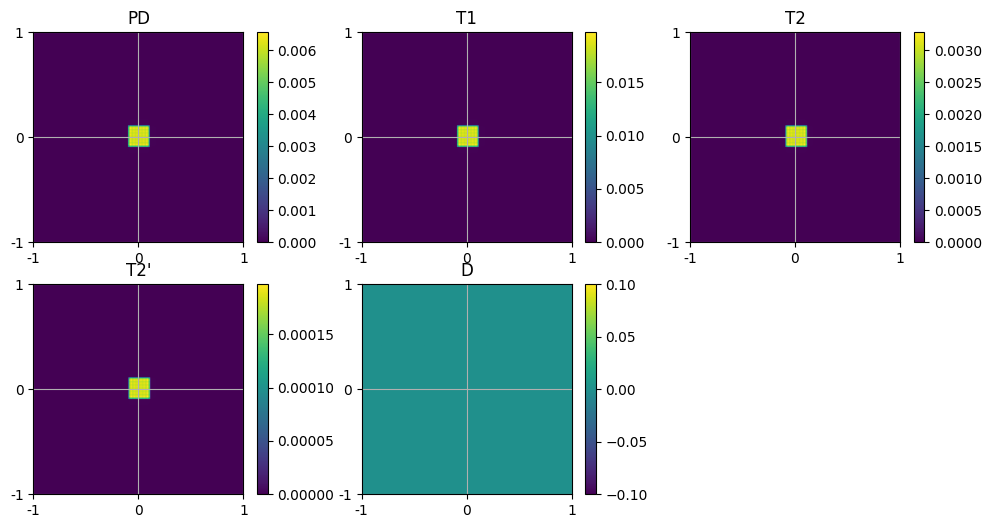

In [3]:
#@title 1D SE in a pixel phantom - simulation
dB0 = 0
obj_p = mr0.CustomVoxelPhantom(
        pos=[[0., 0., 0]],
        PD=[1.0],
        T1=[3.0],
        T2=[0.5],
        T2dash=[30e-3],
        D=[0.0],
        B0=0,
        voxel_size=0.1,
        voxel_shape="box"
    )
# Manipulate loaded data
obj_p.B0+=dB0
obj_p.D*=0
obj_p.plot()
# Convert Phantom into simulation data
obj_p=obj_p.build()

# %% SIMULATE  the external.seq file and add acquired signal to ADC plot
# Read in the sequence
seq0 = mr0.Sequence.import_file(experiment_id + '.seq')
# Simulate the sequence
graph=mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal=mr0.execute_graph(graph, seq0, obj_p, print_progress=False)
# PLOT sequence with signal in the ADC subplot
# seq.plot(plot_now=False)
# mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
# plt.show()


Text(0, 0.5, 'Amplitude')

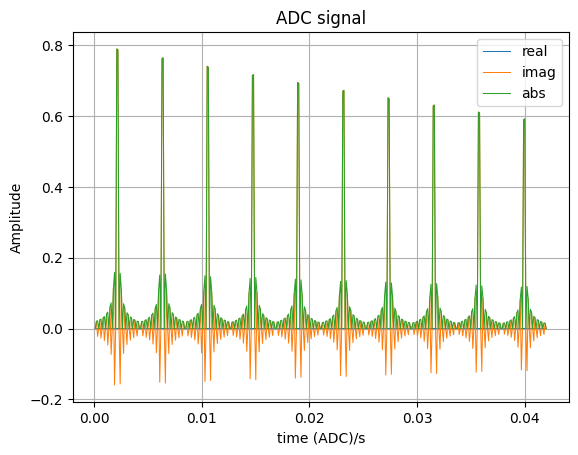

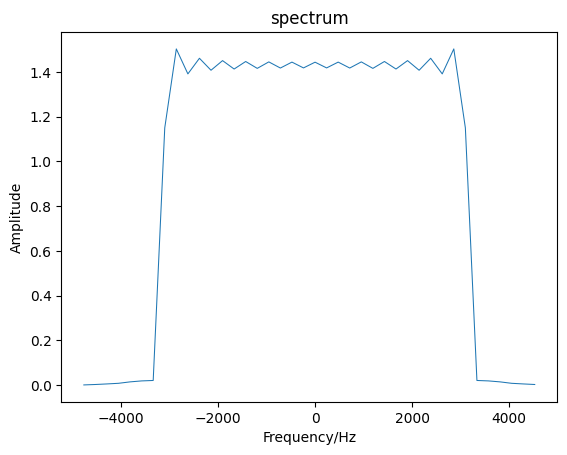

In [4]:
#@title 1D SE in a pixel phantom - simulation
# 1D FFT
def fft_1d(x):
    return np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(x)))

# detailed ADC plot for one repetition
plt.figure()
plt.title('ADC signal')
# time axis
time_axis=np.linspace(1, nRD*n_echo, nRD*n_echo)*adc.dwell ;
plt.plot(time_axis, np.real(signal), label='real')
plt.plot(time_axis, np.imag(signal), label='imag')
plt.plot(time_axis, np.abs(signal), label='abs')
plt.grid()
plt.legend(loc="upper right")
plt.xlabel('time (ADC)/s')
plt.ylabel('Amplitude')

# FFT reconstruction
spectrum = fft_1d(signal[0:nRD,:])

# frequency axis
freq_axis = np.linspace(-nRD/2, nRD/2-1, nRD)/(adc.dwell*adc.num_samples) ; # remain to be checked whether -1 should be included or not

plt.figure()
plt.title('spectrum')
plt.plot(freq_axis, np.abs(spectrum[0:nRD,:]))
plt.xlabel('Frequency/Hz')
plt.ylabel('Amplitude')